<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VIT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install timm


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # For using pretrained Vision Transformer models

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Typical input size for ViT models
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use Pre-trained Vision Transformer (ViT) model and modify it for binary classification
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Modify the classifier to output 2 classes

    def forward(self, x):
        return self.vit(x)

# Initialize the ViT model
model = ViTModified()

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop with learning rate scheduler
# Training loop with learning rate scheduler and checkpoint saving
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save checkpoint of the latest model after each epoch
        latest_model_path = os.path.join(checkpoint_folder, f"latest_model_vit_{date_str}.pth")
        torch.save(model.state_dict(), latest_model_path)
        print(f"Checkpoint saved for epoch {epoch + 1} at {latest_model_path}")

        # Save the best model if the accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_vit_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training loss and validation accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model at the end of training
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vit_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")


# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.293969
Validation Accuracy: 96.84%
Checkpoint saved for epoch 1 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch1.pth
New best model saved with accuracy: 96.84% at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/best_model_vit_20241114.pth
Epoch [2/20], Loss: 0.098213
Validation Accuracy: 96.20%
Checkpoint saved for epoch 2 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch2.pth
Epoch [3/20], Loss: 0.078977
Validation Accuracy: 98.10%
Checkpoint saved for epoch 3 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch3.pth
New best model saved with accuracy: 98.10% at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/best_model_vit_20241114.pth
Epoch [4/20], Loss: 0.075795
Validation Accuracy: 96.20%
Checkpoint saved for epoch 4 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model checkpoint found.
Test folder found.


<ipython-input-4-6e23ad577680>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded successfully from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth
Test Accuracy: 91.30%


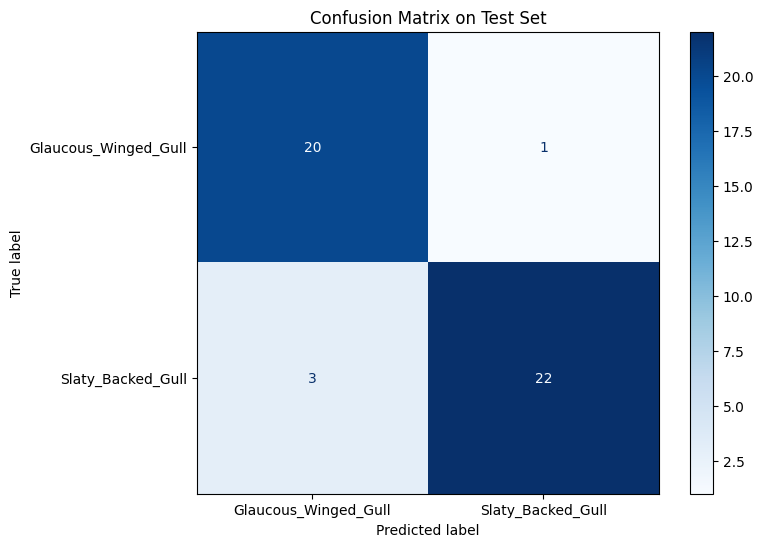

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from google.colab import drive  # For connecting to Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the model checkpoint and test folder in Google Drive
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'  # Update with the path to your test folder

# Verify paths
if not os.path.exists(checkpoint_path):
    print("Model checkpoint not found. Check the path.")
else:
    print("Model checkpoint found.")

if not os.path.exists(test_data_path):
    print("Test folder not found. Check the path.")
else:
    print("Test folder found.")

# Define the modified ViT model
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Binary classifier

    def forward(self, x):
        return self.vit(x)

# Load the model
def load_vit_model(checkpoint_path):
    model = ViTModified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    print("Model loaded successfully from", checkpoint_path)
    return model

model = load_vit_model(checkpoint_path)

# Define transformations to match the ones used during training
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the test dataset
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define class names (update based on your dataset)
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']

# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate on test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-6-6fb325a3063b>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded successfully from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth


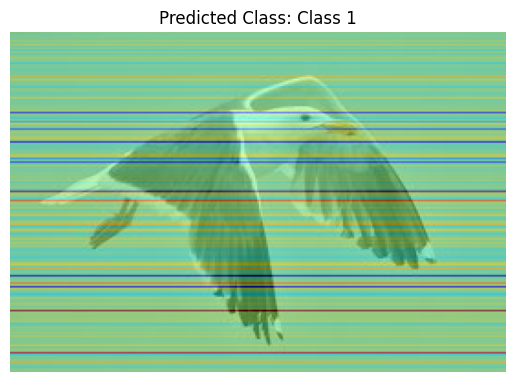

In [ ]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import timm  # For pretrained ViT models
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your model checkpoint and test image in Google Drive
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth'
image_path = '/content/sbg.jpg'  # Update with actual path to your image

# Define the modified ViT model
class ViTModified(torch.nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = torch.nn.Linear(num_ftrs, 2)  # Adjust for binary classification

    def forward(self, x):
        return self.vit(x)

# Load the model
def load_vit_model(checkpoint_path):
    model = ViTModified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    print("Model loaded successfully from", checkpoint_path)
    return model

model = load_vit_model(checkpoint_path)

# Function for Attention Rollout
class AttentionRollout:
    def __init__(self, model, discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        self.attentions = []

        # Register hooks to capture attention weights
        for blk in self.model.vit.blocks:
            blk.attn.proj.register_forward_hook(self.save_attention)

    def save_attention(self, module, input, output):
        self.attentions.append(output.detach())

    def rollout(self):
        # Initialize identity matrix
        result = torch.eye(self.attentions[0].size(-1))

        # Accumulate attention weights
        for attention in self.attentions:
            attention_heads = attention.mean(1)  # Average across heads
            flat_attention = attention_heads.view(-1, attention_heads.size(-1))
            # Normalize and set least important attention to zero
            flat_attention = flat_attention / flat_attention.sum(dim=-1, keepdim=True)
            result = result + torch.matmul(flat_attention, result)

        # Remove the CLS token attention
        mask = result[0, 1:]
        return mask.cpu().numpy()

# Visualization function for the attention map
def show_attention_on_image(img, mask, predicted_class):
    # Resize the mask to match the image size
    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask_resized -= np.min(mask_resized)
    mask_resized /= np.max(mask_resized)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(cam)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Set up the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_np = np.array(image) / 255.0  # Normalize image for display

# Predict class
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_idx = output.argmax().item()
    predicted_class = f"Class {predicted_idx}"

# Apply Attention Rollout
attn_rollout = AttentionRollout(model)
_ = model(input_tensor)  # Forward pass to trigger hooks
mask = attn_rollout.rollout()

# Show the attention map
show_attention_on_image(image_np, mask, predicted_class)


CONF MATRIX

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


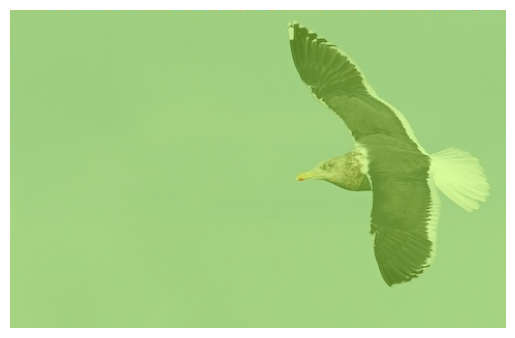

In [3]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from timm.models.vision_transformer import VisionTransformer
from google.colab import drive  # For connecting to Google Drive


# Mount Google Drive
drive.mount('/content/drive')

class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.attention_weights = []

        # Register hooks
        for blk in self.model.blocks:
            blk.attn.register_forward_hook(self.save_attention)
            blk.attn.proj.register_backward_hook(self.save_gradient)

    def save_attention(self, module, input, output):
        self.attention_weights.append(output)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output[0, target_class].backward()

        # Aggregate attention and gradients
        avg_attention = torch.stack(self.attention_weights).mean(dim=1)
        avg_gradients = torch.stack(self.gradients).mean(dim=1)
        grad_weighted_attention = avg_attention * avg_gradients
        cam = grad_weighted_attention.mean(dim=0).detach().cpu()

        return cam

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image_path = "/content/drive/My Drive/FYP/test data/480 (3).jpeg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Load pre-trained ViT model and initialize Grad-CAM
model = VisionTransformer(patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, num_classes=2)
vit_grad_cam = ViTGradCAM(model)

# Generate CAM and visualize
cam = vit_grad_cam.generate_cam(input_tensor, target_class=1)
cam_resized = np.array(Image.fromarray(cam.numpy()).resize((image.width, image.height)))
plt.imshow(np.array(image) / 255.0)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()
